In [1]:
## Updated by gavento based on code by Sudarsh

from transformer_lens import HookedTransformer
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.neighbors import BallTree

# Load the pre-trained model
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


model1 = HookedTransformer.from_pretrained("gpt2", device=device)
model2 = HookedTransformer.from_pretrained("Qwen/Qwen2-0.5b")
# gemma_model = HookedTransformer.from_pretrained("gemma-2b", device="mps")
torch.set_printoptions(threshold=1_000_000)
torch.set_printoptions(linewidth=1_000_000)

/usr/local/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Loaded pretrained model Qwen/Qwen2-0.5b into HookedTransformer


In [2]:
# Define the input text
input_text = """Relative entropy is always a non-negative real number, with value 0 if and only if the two distributions in question are identical. It has diverse applications, both theoretical, such as characterizing the relative (Shannon) entropy in information systems, randomness in continuous time-series, and information gain when comparing statistical models of inference; and practical, such as applied statistics, fluid mechanics, neuroscience, bioinformatics, and machine learning."""

# Tokenize the input text
model1tokens = model1.to_tokens(input_text)[:, 1:] # Skip BOS
model2tokens = model2.to_tokens(input_text)[:, 1:]


# embeddings_tree = BallTree(W_E.numpy(), leaf_size=1)

SOFT_TOKENS = 10
MODEL_1_DIM = 768
MODEL_2_DIM = 896
L2REG = 0.5

def exec_model(model, first_tokens_embedding, tokens):
    residual, _tks, _spe, _attn = model.input_to_embed(tokens)
    both = torch.concat([first_tokens_embedding, residual], axis=1)
    #print(first_tokens_embedding.shape, residual.shape, both.shape)
    return model(both, start_at_layer=0)

def predict(model, first_tokens_embedding, num_tokens):
    tokens = []
    for i in range(num_tokens):
        toks = torch.tensor(tokens, dtype=torch.long)
        residual, _tks, _spe, _attn = model.input_to_embed(toks)
        both = torch.concat([first_tokens_embedding.detach(), residual], axis=1)
        res = model(both, start_at_layer=0)[0]
        next_token = torch.argmax(res, axis=-1)[-1].item()  # Get the last token predicted
        tokens.append(next_token)
        #print(model.tokenizer.convert_ids_to_tokens(tokens))
        #print(residual.shape, toks.shape, both.shape, res.shape, probs.shape)
    
    return (model.tokenizer.decode(tokens),
            model.tokenizer.convert_ids_to_tokens(tokens),
            torch.tensor(tokens).cpu())  # Convert the final token list to a tensor


def token_alignment_loss(logits, tokens, first_tokens_embedding, gamma=0.2):
    # Calculate the cross-entropy loss
    def l2(x): return torch.sum(x ** 2) ** 0.5

    logits = logits[SOFT_TOKENS - 1:-1, :]

    ce_loss = F.cross_entropy(logits, tokens)
    l2_loss = l2(first_tokens_embedding)

    total_loss = ce_loss + gamma * l2_loss

    return total_loss



0

Step 0, Maximum Correct=0, Correct=0, Loss=567.2493896484375/0, 24.535686492919922, 542.7136840820312 L2=80.63400268554688, LR=[0.19894313879210052], Pred=' the the.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', Pred2='自营的“ 遥 远 远 远 远 远 远 远'
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50

Step 50, Maximum Correct=0, Correct=0, Loss=321.9294128417969/0, 18.26626968383789, 303.66314697265625 L2=60.83761978149414, LR=[0.15264320137581455], Pred='.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', Pred2='Relative entropy is always a non-negative integer, zero, or a finite real number, real, rational'
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

Step 100, Maximum Correct=1, Correct=1, Loss=178.6014404296875/1, 15.949251174926758, 162.65219116210938 L2=52.91704559326172, LR=[0.1171186252902463], Pred='L the the 

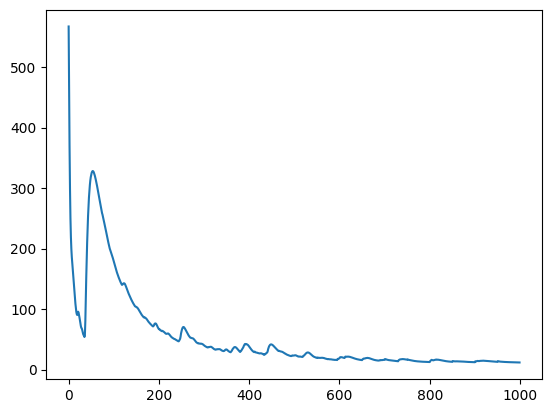

In [3]:
import math

first_tokens_embedding = torch.randn(size=(1, SOFT_TOKENS, MODEL_1_DIM), dtype=torch.float32, device=device)
translation_matrix = torch.randn(size=(MODEL_1_DIM, MODEL_2_DIM)).cuda()
if device == "cuda": 
    first_tokens_embedding = first_tokens_embedding.cuda()
if device == "mps":
    first_tokens_embedding = first_tokens_embedding.to(torch.float32).to(device)

first_tokens_embedding = first_tokens_embedding.requires_grad_(True)

num_steps = 1000  # Number of optimization steps
optimizer = torch.optim.Adam([first_tokens_embedding, translation_matrix], lr=0.02 * SOFT_TOKENS, amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)

loss_arr = []

def l2(x): return torch.sum(x ** 2) ** 0.5

last_corr = 0
max_corr = 0
lossahead = 5 + SOFT_TOKENS * 2
lookahead = 20
kappa = 0.1
alpha = 0.0
beta = 1.0
for step in range(num_steps):
    # Zero the gradients
    optimizer.zero_grad()

    logits_1= exec_model(model1, first_tokens_embedding, model1tokens)

    flattened_logits_1 = logits_1.flatten(0, 1)[:last_corr+lookahead+SOFT_TOKENS]
    flattened_tokens_1 = model1tokens.flatten(0, 1)[:last_corr+lookahead]

    logits_2 = exec_model(model2, 
                          first_tokens_embedding @ translation_matrix, 
                          model2tokens)

    flattened_logits_2 = logits_2.flatten(0, 1)[:last_corr + lookahead + SOFT_TOKENS]
    flattened_tokens_2 = model2tokens.flatten(0, 1)[:last_corr+lookahead]

    loss_1 = token_alignment_loss(flattened_logits_1, flattened_tokens_1, first_tokens_embedding)
    loss_2 = token_alignment_loss(flattened_logits_2, flattened_tokens_2,  first_tokens_embedding @ translation_matrix)

    loss = loss_1 + loss_2
    
    # Backpropagate the loss with retain_graph=True
    loss.backward()

    # Optimize the first token's embedding
    optimizer.step()
    lr_scheduler.step()

    loss_arr.append(loss.item())

    # Print the loss for every 100 steps
    print(step)
    if step % 50 == 0:
        with torch.no_grad():  # Disable gradient computation for prediction

            ps = predict(model1, first_tokens_embedding, last_corr+lookahead)
            ps_2 = predict(model2,  first_tokens_embedding @ translation_matrix, last_corr + lookahead)
            temp_corr = (ps[2][:min(last_corr+lookahead, model1tokens.shape[1])] == model1tokens[:, :last_corr+lookahead].cpu()).sum()
            max_corr = max(temp_corr, max_corr)
            if temp_corr > last_corr:
                last_corr += math.ceil((temp_corr - last_corr) / 4)
            print(f"\nStep {step}, Maximum Correct={max_corr}, Correct={temp_corr}, Loss={loss.item()}/{last_corr}, {loss_1.item()}, {loss_2.item()} L2={l2(first_tokens_embedding).detach().cpu()}, LR={lr_scheduler.get_last_lr()}, Pred={ps[0]!r}, Pred2={ps_2[0]!r}")
    

    # just comment out this part if you want to not add tokens
    # if step % 20 == 0 and step != 0:
    #     new_tokens_embedding = torch.tensor(np.random.normal(0.0, 768**(-0.5), size=(1, 1, MODEL_DIM)), dtype=torch.float32, requires_grad=True).to(device)
    #     print("ADDING NEW TOK")
    #     first_tokens_embedding = torch.cat([ new_tokens_embedding, first_tokens_embedding], dim=1)
    #     first_tokens_embedding = first_tokens_embedding.detach().requires_grad_(True)

    #     # Reinitialize the optimizer with the updated embedding
    #     optimizer = torch.optim.Adam([first_tokens_embedding], lr=0.02, amsgrad=True)
    #     lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)


plt.plot(loss_arr)

In [4]:
text_two = "Consensus is lacking among historians with regard to what the actual events surrounding this event. The portrayal of Ahuntisc and Viel as martyrs in popular culture is objected to by those researchers who reject the notion that they were murdered. The ethnic identity and the actual phonetic name of the missionary referred to as Ahuntsic are also not universally agreed upon by authors."

first_embed = torch.randn(size=(1, SOFT_TOKENS, MODEL_1_DIM), dtype=torch.float32, device=device, requires_grad=True).cuda()


model = model1
tokens = model.to_tokens(text_two)[:, 1:] # Skip BOS
print(tokens.shape, tokens)
print(model.tokenizer.convert_ids_to_tokens(tokens[0]))
num_steps = 1000
optimizer = torch.optim.Adam([first_embed], lr=0.02 * SOFT_TOKENS, amsgrad=True)
# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)

last_corr = 0
max_corr = 0
lossahead = 5 + SOFT_TOKENS * 2
lookahead = 20
for step in range(num_steps):
    optimizer.zero_grad()

    # Assuming exec_model correctly processes the model input with first_tokens_embedding
    logits = exec_model(model, first_embed, tokens)

    flattened_logits = logits.flatten(0, 1)[:last_corr+lookahead+SOFT_TOKENS]
    flattened_tokens = tokens.flatten(0, 1)[:last_corr+lookahead]

    loss = token_alignment_loss(flattened_logits, flattened_tokens, first_tokens_embedding)
    
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    loss_arr.append(loss.item())

    print(step)
    if step % 50 == 0:
        with torch.no_grad():  # Disable gradient computation for prediction
            ps = predict(model, first_embed, last_corr+lookahead)
            temp_corr = (ps[2][:min(last_corr+lookahead, tokens.shape[1])] == tokens[:, :last_corr+lookahead].cpu()).sum()
            max_corr = max(temp_corr, max_corr)
            if temp_corr > last_corr:
                last_corr += math.ceil((temp_corr - last_corr) / 4)
            print(f"\nStep {step}, Maximum Correct={max_corr}, Correct={temp_corr}, Loss={loss.item()}/{last_corr}, L2={l2(first_embed).detach().cpu()}, LR={lr_scheduler.get_last_lr()}, Pred={ps[0]!r}")

torch.Size([1, 74]) tensor([[ 9444,  7314,   318, 14394,  1871, 21262,   351,  2754,   284,   644,   262,  4036,  2995,  7346,   428,  1785,    13,   383, 33578,   286,  7900,  2797,  2304,   290,   569,  8207,   355, 28009,    82,   287,  2968,  3968,   318, 29811,   284,   416,   883,  4837,   508,  4968,   262,  9495,   326,   484,   547, 12864,    13,   383,  9450,  5369,   290,   262,  4036, 32896,  5139,  1438,   286,   262, 34692,  6412,   284,   355,  7900, 34115,   291,   389,   635,   407, 26208,  4987,  2402,   416,  7035,    13]], device='cuda:0')
['Cons', 'ensus', 'Ġis', 'Ġlacking', 'Ġamong', 'Ġhistorians', 'Ġwith', 'Ġregard', 'Ġto', 'Ġwhat', 'Ġthe', 'Ġactual', 'Ġevents', 'Ġsurrounding', 'Ġthis', 'Ġevent', '.', 'ĠThe', 'Ġportrayal', 'Ġof', 'ĠAh', 'unt', 'isc', 'Ġand', 'ĠV', 'iel', 'Ġas', 'Ġmartyr', 's', 'Ġin', 'Ġpopular', 'Ġculture', 'Ġis', 'Ġobjected', 'Ġto', 'Ġby', 'Ġthose', 'Ġresearchers', 'Ġwho', 'Ġreject', 'Ġthe', 'Ġnotion', 'Ġthat', 'Ġthey', 'Ġwere', 'Ġmurdered', '.'